# SchrodingerEq.jl

A project for the Computational Physics UW course (module III), by Laura Sberna. In this project, composed of two notebooks, we solve the time dependent Shroedinger equation in one spatial dimension.

The time dependent Schrodinger equation describes the evolution of the wavefunction $\Psi$ of a quantum system. In one spatial dimension, the equation reads

\begin{equation}
i \hbar \frac{\partial \Psi}{\partial t} = -\frac{\hbar^2}{2 m} \frac{\partial^2 \Psi}{\partial^2 x} + V(x) \Psi \ ,
\end{equation}

where $t$ is the time parameter, $x$ is the space coordinate, $m$ the mass of the particle and $\hbar$ is the Plank constant. The probability density to find the particle at the position $x$ at time $t$ will be given by $|\Psi|^2$. 
 

We upload the necessary packages and set some parameters:

In [1]:
using LinearAlgebra
using Plots

In [2]:
m = 16.
hbar = 1.
t0 = 0.

0.0

A large mass (or a small $\hbar$) will make the particle more classical.

## PLC Functions

I use the Piecewise Linear Continuous functions discussed in [class](https://github.com/eschnett/2018-computational-physics-course/tree/master/pde-solving-module). 

In [3]:
struct PLCFun{T,U}
    points::Vector{U}
end

In [4]:
function Base. *(a::U, f::PLCFun{T,U})::PLCFun{T,U} where {T,U}
 PLCFun{T,U}(a .* f.points)
end

function Base. +(g::PLCFun{T,U}, f::PLCFun{T,U})::PLCFun{T,U} where {T,U}
    @assert length(f.points) == length(g.points) ## gives error message if not satisfied
 PLCFun{T,U}(g.points .+ f.points)
end

In [5]:
function xcoord(::Type{T}, nlines::Int, i::Int)::T where {T,U}
    dx = 1 / nlines
    @assert 1 <= i <= nlines+1
    x = (i-1) * dx
    x
end

xcoord (generic function with 1 method)

In [6]:
function lineindex(f::PLCFun{T,U}, x::T)::Int where {T,U}
    @assert 0 <= x <= 1
    nlines=length(f.points)-1
    dx = 1 / nlines
    i = floor(Int, x / dx) + 1
    i = max(1,i)
    i = min(nlines, i)
    i
end

lineindex (generic function with 1 method)

In [7]:
function samplePLC(::Type{T}, ::Type{U}, nlines::Int, f::Function)::PLCFun{T,U} where {T,U}
    ys = U[f(xcoord(T, nlines, i)) for i in 1:nlines+1]
    PLCFun{T,U}(ys)
end

samplePLC (generic function with 1 method)

In [8]:
function linterp(x1::T, y1::U, x2::T, y2::U, x::T)::U where {T,U}
    y1 * (x - x2) / (x1 - x2) + y2 * (x - x1) / (x2 - x1)
end

linterp (generic function with 1 method)

In [9]:
function evaluate(f::PLCFun{T,U}, x::T)::U where {T,U}
    @assert 0 <= x <= 1
    nlines=length(f.points)-1
    i = lineindex(f, x)
    x1=xcoord(T, nlines, i)
    x2=xcoord(T, nlines, i+1)
    y1=f.points[i]
    y2=f.points[i+1]
    y = linterp(x1, y1, x2, y2, x)
    y
end

evaluate (generic function with 1 method)

The second order central finite diferrence scheme for the second order derivative is obtained as follows. We write the Taylor expansions
\begin{align}
f(x_{j-1})&=f(x_j)-\Delta x f'(x_j) + \frac{\Delta x^2}{2} f''(x_j) + O(\Delta x ^3)\\ 
f(x_{j})&=f(x_j) \\
f(x_{j+1})&=f(x_j)+\Delta x f'(x_j) + \frac{\Delta x^2}{2} f''(x_j) + O(\Delta x ^3) \\ 
\end{align}
from which
\begin{equation}
f''(x_j) = \frac{f(x_{j+1}) -2f(x_{j}) + f(x_{j-1})}{\Delta x^2} + O(\Delta x) 
\end{equation}
We also put the system in a box: at the endpoints, we use the left or right scheme:

\begin{align}
f''(x_j) &= \frac{ f(x_{j+2})-2 f(x_{j+1})) }{\Delta x^2} + O(\Delta x ^3)  \ \ \ (left \ boundary) \\ 
f''(x_j) &= \frac{f(x_{j-2})-2 f(x_{j-1}) }{\Delta x^2} + O(\Delta x ^3)  \ \ \ (right \  boundary)
\end{align}

In [10]:
function derivSecondCenter(f::PLCFun{T,U})::PLCFun{T,U} where {T,U} 
    nlines=length(f.points)-1
    dx = 1 / nlines  # + f.points[1]  + f.points[i-1]
    ys=U[(f.points[3] - 2*f.points[2] ) /(dx^2) ;[(f.points[i+1] - 2*f.points[i]) /(dx^2) for i in 2:nlines]; (f.points[end-2] - 2*f.points[end-1] + f.points[end]) /(dx^2)]
    PLCFun{T,U}(ys)
end

derivSecondCenter (generic function with 1 method)

## The Schroedinger equation

Implicit methods for parabolic equations require very small time steps. For this reason it is better to implement higher order time integrators than Euler, like Runge-Kutta 2 or 4.
In this section of the code we define some structures, the functions for the different time evolution methods, the main solver and some other useful functions.

In [11]:
struct WaveFunction{T, U}
    time::T
    psi::PLCFun{T,U}
end

In [12]:
function Base. *(a::U, f::WaveFunction{T, U})::WaveFunction{T, U} where {T,U}
 WaveFunction{T, U}(f.time, a * f.psi)
end

function Base. *(v::PLCFun{T,Float64}, f::PLCFun{T,U})::PLCFun{T,U} where {T,U}
    @assert length(v.points)==length(f.points)
    PLCFun{T,U}(v.points .* f.points)
end

function Base. +(g::WaveFunction{T, U}, f::WaveFunction{T, U})::WaveFunction{T, U} where {T,U}
    @assert abs(f.time - g.time) <= 100*eps(T)
 WaveFunction{T, U}(f.time, g.psi + f.psi)
end

Initial wave function: we choose a Gaussian centered at $x_0$, with momentum $p$ and width $\sigma_x$
\begin{equation}
\Psi_0(x)= \frac{1}{(\pi \sigma_x^2)^{1/4}} \ e^{-\frac{(x-x_0)^2}{2 \sigma_x^2} + i p (x-x_0)}
\end{equation}

In [13]:
function gaussian(x::T, x0::T, sigmax::T, p::T)::Complex{Float64} where {T}
    1 / sqrt(sqrt(pi * sigmax^2)) * exp( - (x-x0)^2 / ( 2 * sigmax^2 ) + im * p * (x-x0))
end

gaussian (generic function with 1 method)

In [14]:
function initialGaussian(nlines::Int, x0::Float64, sigmax::Float64, p::Float64)::WaveFunction{Float64, Complex{Float64}}
    t = 0
    y = samplePLC(Float64, Complex{Float64}, nlines, x -> gaussian(x,x0,sigmax,p))
    WaveFunction{Float64, Complex{Float64}}(t,y)
end

initialGaussian (generic function with 1 method)

In [15]:
function potential(nlines::Int)::PLCFun{Float64,Float64}
    samplePLC(Float64, Float64, nlines,V)
end

potential (generic function with 1 method)

In [16]:
function rhsSchroedinger(s::WaveFunction{T, U})::WaveFunction{T, U} where {T,U}
    t = s.time
    psi = s.psi
    nlines = length(psi.points) - 1
    psixx = (- im / hbar) * ((- hbar^2 / ( 2*m) + im * 0.) * derivSecondCenter(psi) + potential(nlines) * psi)
    psit = PLCFun{T,U}(U[0;[psixx.points[i] for i in 2:nlines]; 0])
    WaveFunction{T, U}(t, psit)
end

rhsSchroedinger (generic function with 1 method)

In [17]:
function euler(rhs::Function, dt::T,
               s0::WaveFunction{T, U})::WaveFunction{T, U} where {T,U}
    r0 = rhs(s0)
    s1 = s0 + (dt + im * 0.)  * r0
    WaveFunction{T, U}(r0.time + dt, s1.psi)
end

euler (generic function with 1 method)

In [18]:
function RK2(rhs::Function, dt::T,
               s0::WaveFunction{T, U})::WaveFunction{T, U} where {T,U}
    r0 = rhs(s0)
    smiddle = s0 + (dt / 2 + im * 0.)  * r0
    rmiddle = rhs(smiddle)
    s1 = s0 + (dt + im * 0.)  * rmiddle
    WaveFunction{T, U}(r0.time + dt, s1.psi)
end

RK2 (generic function with 1 method)

In [19]:
function RK4(rhs::Function, dt::T,
               s0::WaveFunction{T, U})::WaveFunction{T, U} where {T,U}
    k1 = rhs(s0)
    k2 = rhs(s0 + (dt / 2 + im * 0.)  * k1)
    k3 = rhs(s0 + (dt / 2 + im * 0.)  * k2)
    k4 = rhs(s0 + (dt  + im * 0.)  * k3)
    s1 = s0 + (dt / 6 + im * 0.)  * (k1 + (2. + im * 0.) *k2 + (2. + im * 0.) *k3 + k4)
    WaveFunction{T, U}(s0.time + dt, s1.psi)
end

RK4 (generic function with 1 method)

In [20]:
struct solution{T,U}
    dt::T
    dx::T
    states::Vector{WaveFunction{T, U}}
end

In [21]:
function solveSchrodinger(tmax::T, nlines::Int, lambda::T, x0::T, sigmax::T, p::T) where {T}
    s=initialGaussian(nlines, x0, sigmax, p)
    dx= 1/nlines
    dt=lambda * dx
    nsteps= round(Int, tmax / dt)
    sol = solution{T,Complex{T}}(dt, dx, WaveFunction{T, Complex{T}}[])
    push!(sol.states, s)
    
    for step in 1:nsteps
        s = RK4(rhsSchroedinger, dt, s)
        push!(sol.states, s)
    end
    return sol
end

solveSchrodinger (generic function with 1 method)

In [22]:
function refine(u::PLCFun{T,U})::PLCFun{T,U} where {T,U} # doubles the number of points of the PLC
    nlines = length(u.points) - 1
    dx = 1 / nlines
    eval = [evaluate(u, xcoord(T, 2 * nlines, i)) for i in 1:2*nlines+1]
    PLCFun{T,U}(eval)
end

refine (generic function with 1 method)

In [23]:
function totprob(u::PLCFun{T,U}, dx::T)::T where {T,U} # computes the total probability / the innerproduct
    dx*sum(abs.(u.points) .^2)
end

totprob (generic function with 1 method)

## Free particle in a box

We test the code for a vanishing potential, $V=0$.

In [24]:
function V(x::T)::Float64 where {T}
    0.
end

V (generic function with 1 method)

In [25]:
# analytic solution
psianalyticsol(x,t) = 1 /pi^(1/4) / sqrt(sigmax + im*hbar*t /(m*sigmax)) * exp(- im * t*p^2 / (2*m) + im * p * (x-x0) - (x -x0 - hbar*p*t/m)^2/(2*(sigmax^2 + im*hbar*t / m)) )

psianalyticsol (generic function with 1 method)

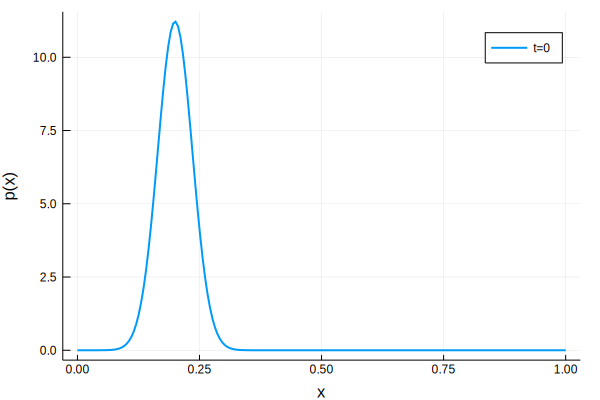

In [26]:
x0 = 0.2
sigmax = 0.05
p = 32.
n = 200
T = 0.25
lambda = 0.05  
s0 = initialGaussian(n, x0, sigmax, p)
xs = collect(range(0, stop=1, length=n))
sol1 = solveSchrodinger(T, n, lambda, x0, sigmax, p);
plot(xs, [abs(evaluate(s0.psi, x))^2 for x in xs], label = "t=0", xlabel="x", ylabel = "p(x)",
    linewidth = 2 )

An animation of the solution. The dashed vertical line indicates the classical evolution of a free particle starting at $x_0$ with momentum $p \hbar$. The dashed wavefunction is the analytical solution for a Gaussian initial state without box boundary conditions. The analytical and numerical solutions appear to be in excellent agreement before encountering the box wall. 

In [28]:
anim = @animate for i=1:length(sol1.states)
    plot(xs, [abs(evaluate(sol1.states[i].psi, x))^2 for x in xs], xlabel = "x", ylabel = "p(x)", legend = :false, 
    xlim = (0,1), ylim = (0,11.5), linewidth = 2)
    plot!([x0 + p / m * (lambda / n * i) * hbar], seriestype = :vline, linestyle = :dash, 
        linecolor= :black, linealpha= 0.8)
    plot!(xs,[abs(psianalyticsol(x,i*lambda/n))^2 for x in xs], linestyle= :dash, linealpha= 0.6, linewidth = 2)
    end every 10
#gif(anim, "freeparticle.gif", fps=15)
gif(anim, fps=15)e

┌ Info: Saved animation to 
│   fn = /Users/laurasberna/JuliaProjects/DifferentialEquationsModule.jl/SchrodingerEq.jl/tmp.gif
└ @ Plots /Users/laurasberna/.julia/packages/Plots/rmogG/src/animation.jl:90


Plots.AnimatedGif("/Users/laurasberna/JuliaProjects/DifferentialEquationsModule.jl/SchrodingerEq.jl/tmp.gif")

In [62]:
anim = @animate for i=1:length(sol1.states)
    plot(xs, [real(evaluate(sol1.states[i].psi, x)) for x in xs], xlabel = "x", ylabel = "Re(Psi)", legend = :false, 
    xlim = (0,1), ylim = (-5,5), linewidth = 2)
    #plot!([x0 + p / m * (lambda / n * i) * hbar], seriestype = :vline, linestyle = :dash, 
     #   linecolor= :black, linealpha= 0.8)
    plot!(xs,[real(psianalyticsol(x,i*lambda/n)) for x in xs], linestyle= :dash, linealpha= 0.6, linecolor = :green)
    end every 10
gif(anim, "freeparticle_real.gif", fps=15)

┌ Info: Saved animation to 
│   fn = /Users/laurasberna/JuliaProjects/DifferentialEquationsModule.jl/SchrodingerEq.jl/freeparticle_real.gif
└ @ Plots /Users/laurasberna/.julia/packages/Plots/rmogG/src/animation.jl:90


Plots.AnimatedGif("/Users/laurasberna/JuliaProjects/DifferentialEquationsModule.jl/SchrodingerEq.jl/freeparticle_real.gif")

In [63]:
anim = @animate for i=1:length(sol1.states)
    plot(xs, [imag(evaluate(sol1.states[i].psi, x)) for x in xs], xlabel = "x", ylabel = "Im(Psi)", legend = :false, 
    xlim = (0,1), ylim = (-5,5), linewidth = 2)
    #plot!([x0 + p / m * (lambda / n * i) * hbar], seriestype = :vline, linestyle = :dash, 
     #   linecolor= :black, linealpha= 0.8)
    plot!(xs,[imag(psianalyticsol(x,i*lambda/n)) for x in xs], linestyle= :dash, linealpha= 0.6, linecolor = :green)
    end every 10
gif(anim, "freeparticle_im.gif", fps=15)

┌ Info: Saved animation to 
│   fn = /Users/laurasberna/JuliaProjects/DifferentialEquationsModule.jl/SchrodingerEq.jl/freeparticle_im.gif
└ @ Plots /Users/laurasberna/.julia/packages/Plots/rmogG/src/animation.jl:90


Plots.AnimatedGif("/Users/laurasberna/JuliaProjects/DifferentialEquationsModule.jl/SchrodingerEq.jl/freeparticle_im.gif")

### Convergence tests

We first check whether the total probability is conserved, i.e. check whether the evolution is unitary. Explicit methods are not expected to conserve probability, in general, since they approximate the evolution operator with a non-unitary operator.

In [65]:
x0 = 0.2
sigmax = 0.05
p = 32.
n = 500
T = 0.25
lambda = 0.01  
xs = collect(range(0, stop=1, length=n))
sol1 = solveSchrodinger(T, n, lambda, x0, sigmax, p);
sol2 = solveSchrodinger(T, 2*n, lambda, x0, sigmax, p);
sol4 = solveSchrodinger(T, 4*n, lambda, x0, sigmax, p);

In [68]:
exactsol = samplePLC(Float64,Complex{Float64}, n, x -> psianalyticsol(x,0));
ts = collect(range(0, stop=T, length=length(sol1.states)));

In [72]:
Int64(floor(length(sol1.states)/2)),Int64(floor(length(sol2.states)/2))

(6250, 12500)

Qualitative agreement between different resolutions and exact solution:

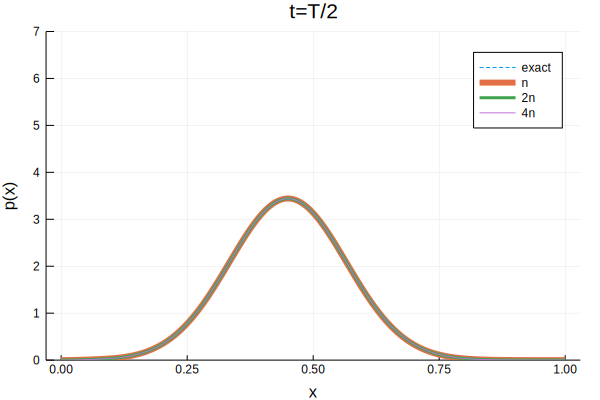

In [75]:
xs2 = collect(range(0, stop=1, length=2*n))
xs4 = collect(range(0, stop=1, length=4*n))
plot(xs,[abs(psianalyticsol(x,T/2))^2 for x in xs], ylim=(0,7), label = "exact", linestyle = :dash,
title = "t=T/2")
plot!(xs, [abs(evaluate(sol1.states[Int64(floor(length(sol1.states)/2))].psi, x))^2 for x in xs], 
    xlabel = "x", ylabel = "p(x)", label = "n", linestyle = :solid, linewidth =6)
plot!(xs2, [abs(evaluate(sol2.states[Int64(floor(length(sol2.states)/2))].psi, x))^2 for x in xs2], 
    xlabel = "x", ylabel = "p(x)", label = "2n", linestyle = :solid, linewidth =3)
plot!(xs4, [abs(evaluate(sol4.states[Int64(floor(length(sol4.states)/2))].psi, x))^2 for x in xs4], 
    xlabel = "x", ylabel = "p(x)", label = "4n",linestyle = :solid, linewidth =1)

The loss of probability is caused by the encounter with the boundary:

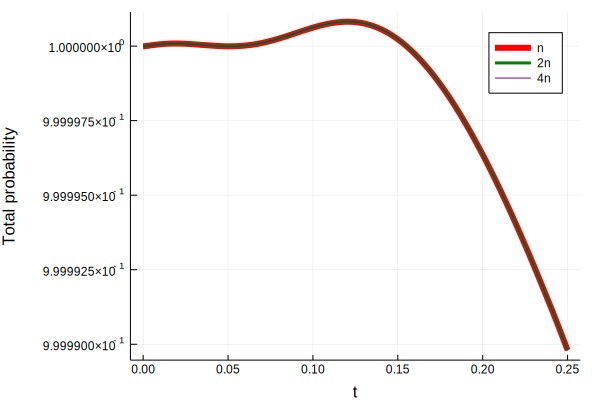

In [86]:
plot([i for i in 0:(lambda / n):T] , [totprob(sol1.states[i].psi, sol1.dx) for i in 1:length(sol1.states)],
    label = "n", linecolor = :red, xlabel = "t", ylabel = "Total probability", linewidth = 6)
plot!([i for i in 0:(lambda/2 / n):T] , [totprob(sol2.states[i].psi, sol2.dx) for i in 1:length(sol2.states)],
label = "2n", linecolor = :green, linewidth = 3)
plot!([i for i in 0:(lambda/4 / n):T] , [totprob(sol4.states[i].psi, sol4.dx) for i in 1:length(sol4.states)],
label = "4n", linecolor = :purple, linewidth = 1)

In [82]:
ue1=[totprob(refine(sol1.states[1+i].psi) + (-1.0 + im * 0.) * sol2.states[1+2*i].psi, sol2.dx) for i in 0:length(sol1.states)-1];
ue2=[totprob(refine(sol2.states[1+2*i].psi) + (-1.0 + im * 0.) * sol4.states[1+4*i].psi, sol4.dx) for i in 0:length(sol1.states)-1];

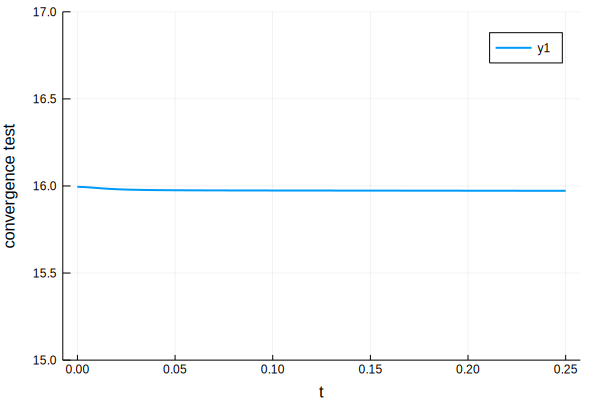

In [90]:
plot(ts, ue1 ./ue2, ylabel = "convergence test", xlabel = "t", linewidth = 2, ylim = (15,17) )

In [91]:
savefig("convtest.png")

The convergence test is consistent with $s^q$ with $q=4$, the order of the RK time algorithm.

Finally, we compare more rigorously the exact and the numerical solutions before hitting the box wall.

In [88]:
exactsolm(t)=samplePLC(Float64,Complex{Float64}, n, x -> - psianalyticsol(x,t))
exactsolm2(t)=samplePLC(Float64,Complex{Float64}, 2*n, x -> - psianalyticsol(x,t))
exactsolm4(t)=samplePLC(Float64,Complex{Float64}, 4*n, x -> - psianalyticsol(x,t))
comp1=[totprob(sol1.states[t].psi + exactsolm((t-1)*sol1.dt), sol1.dx) for t in 1:length(sol1.states)]
comp2=[totprob(sol2.states[t].psi + exactsolm2((t-1)*sol2.dt), sol2.dx) for t in 1:length(sol2.states)]
comp4=[totprob(sol4.states[t].psi + exactsolm4((t-1)*sol4.dt), sol4.dx) for t in 1:length(sol4.states)];

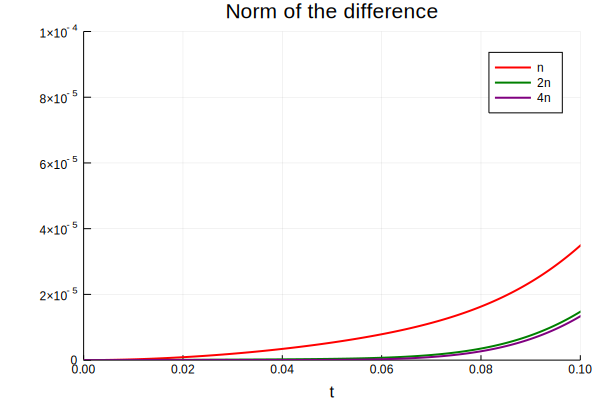

In [94]:
plot(ts, comp1, xlim = (0, 0.1), ylim = (0,0.0001), label ="n", linewidth = 2, linecolor = :red,
title = "Norm of the difference", xlabel = "t")
plot!(collect(range(0, stop=T, length=length(sol2.states))), comp2, label = "2n", linewidth = 2, linecolor = :green)
plot!(collect(range(0, stop=T, length=length(sol4.states))), comp4, label = "4n", linewidth = 2, linecolor = :purple)

In [95]:
savefig("normdiff.png")

We see that the norm of the difference between the numerical and the exact solution decreases as we improve the spatial resolution. 

After this series of tests, we convince ourselves that the code is working. A comparison with a different Shroedinger solver will be performed for the barrier potential. To find out more on the barrier potential, see the notebook [SchrodingerEq-Barrier](https://github.com/laurasberna/SchrodingerEq.jl/blob/master/SchrodingerEq-Barrier.ipynb). 